<a href="https://colab.research.google.com/github/Shriniwas21/CryptoPricePrediction/blob/main/01_data_collection_and_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
!pip install alpha_vantage

In [92]:
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import pandas as pd
import time

# Set your API key here
ALPHA_API_KEY = "1UT1E7OOFC6B3JS5"

cc = CryptoCurrencies(key=ALPHA_API_KEY, output_format='pandas')

In [93]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define path to the dataset in Drive
data_path = '/content/drive/MyDrive/CryptoPricePrediction/data'
btc_path = os.path.join(data_path, 'BTC_day.csv')  # update filename if different

# Load the CSV file
btc = pd.read_csv(btc_path)

# Show first few rows
btc.head()

,timestamp,open,close,high,low,volume
0,1569196800,9930.13,9930.13,9930.13,9930.13,0.001000
1,1569283200,9637.93,8519.67,9665.05,7996.45,202.350799
2,1569369600,8528.12,8435.28,8724.77,8247.78,55.417971
3,1569456000,8434.45,8064.41,8453.20,7761.87,41.880079
4,1569542400,8078.75,8178.73,8259.96,7858.58,47.142904


In [94]:
btc.columns = btc.columns.str.strip().str.lower()  # normalize column names
print(btc.columns.tolist())  # should show all lowercase names

['timestamp', 'open', 'close', 'high', 'low', 'volume']


In [95]:
# Re-read the file in case you're mid-session
btc = pd.read_csv(btc_path)

# Convert timestamp from nanoseconds to datetime
btc['date'] = pd.to_datetime(btc['timestamp'], unit='s')

# Set as index
btc.set_index('date', inplace=True)

# Drop old timestamp column
btc.drop(columns=['timestamp'], inplace=True)

# Sort by date
btc.sort_index(inplace=True)

# Confirm new date range
print(f"Start date: {btc.index.min()}")
print(f"End date: {btc.index.max()}")

# Optional: preview a few rows
btc.head()

Start date: 2019-09-23 00:00:00
End date: 2024-05-09 00:00:00


,open,close,high,low,volume
date,,,,,
2019-09-23,9930.13,9930.13,9930.13,9930.13,0.001000
2019-09-24,9637.93,8519.67,9665.05,7996.45,202.350799
2019-09-25,8528.12,8435.28,8724.77,8247.78,55.417971
2019-09-26,8434.45,8064.41,8453.20,7761.87,41.880079
2019-09-27,8078.75,8178.73,8259.96,7858.58,47.142904


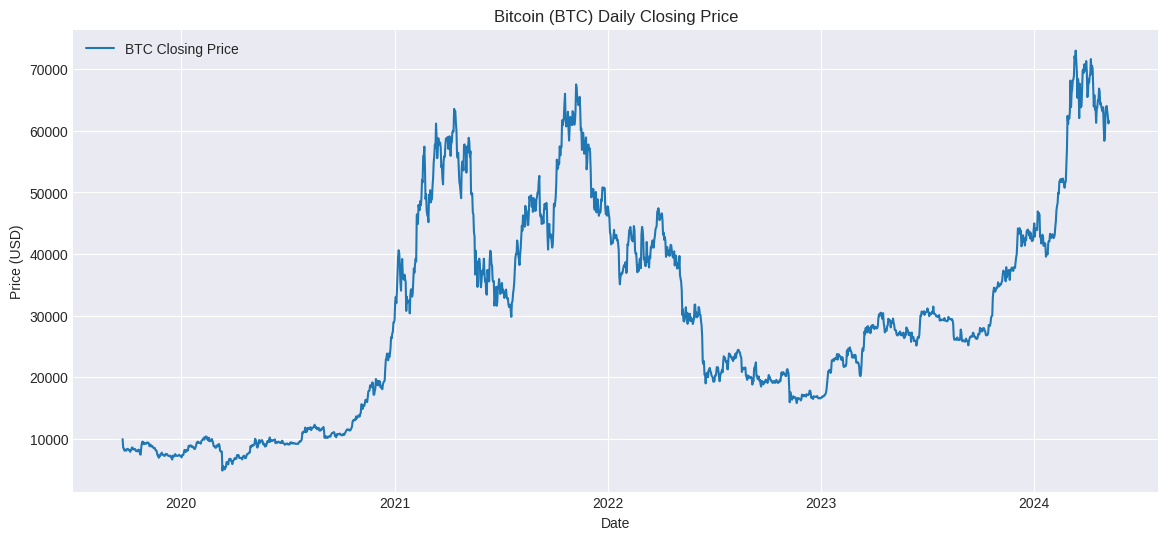

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(btc.index, btc['close'], label='BTC Closing Price')
plt.title('Bitcoin (BTC) Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
btc_av, meta = cc.get_digital_currency_daily(symbol='BTC', market='USD')

# Step 1: Clean column names (strip numbering and lower-case them)
btc_av.columns = [col.split(' ', 1)[-1].strip().lower() for col in btc_av.columns]
print(btc_av.columns.tolist())  # Should show: ['open', 'high', 'low', 'close', 'volume']

# Step 2: Sort index (just to be safe)
btc_av.sort_index(inplace=True)

# Step 3: Keep only relevant columns (you already have all 5)
btc_av = btc_av[['open', 'high', 'low', 'close', 'volume']]

# Preview
btc_av.head()


['open', 'high', 'low', 'close', 'volume']


,open,high,low,close,volume
date,,,,,
2024-04-22,64952.92,67272.73,64520.00,66859.17,10977.051786
2024-04-23,66856.07,67225.66,65823.66,66414.16,8840.167498
2024-04-24,66418.00,67077.97,63542.56,64255.78,15083.552435
2024-04-25,64255.77,65287.69,62747.18,64484.44,13256.298777
2024-04-26,64484.44,64810.00,63287.76,63742.39,10151.962477


In [98]:
# Add suffix _av to all Alpha Vantage columns
btc_av = btc_av.add_suffix('_av')

# Merge full Alpha Vantage dataset with professor's dataset
btc_combined = btc.join(btc_av, how='left')

# Preview all useful columns
btc_combined[['open', 'open_av', 'high', 'high_av', 'low', 'low_av', 'close', 'close_av', 'volume', 'volume_av']].tail()


,open,open_av,high,high_av,low,low_av,close,close_av,volume,volume_av
date,,,,,,,,,,
2024-05-05,63800.39,63902.88,64600.00,64636.75,62910.37,62908.34,64021.14,64023.45,21.25451,4474.519592
2024-05-06,63994.76,64023.45,65460.03,65523.44,62754.30,62704.48,63154.41,63162.24,44.71543,11241.772173
2024-05-07,63176.20,63161.35,64364.22,64415.06,62297.02,62252.64,62358.78,62315.76,34.19785,8994.937730
2024-05-08,62300.00,62315.75,62994.04,63013.05,60909.72,60851.04,61193.08,61169.53,30.54245,7486.425968
2024-05-09,61162.31,61169.53,61563.29,63424.14,61137.33,60601.60,61550.15,63073.57,8.47261,8360.055382


In [99]:
# 7-day and 21-day SMA of closing price
btc_combined['sma_7'] = btc_combined['close'].rolling(window=7).mean()
btc_combined['sma_21'] = btc_combined['close'].rolling(window=21).mean()

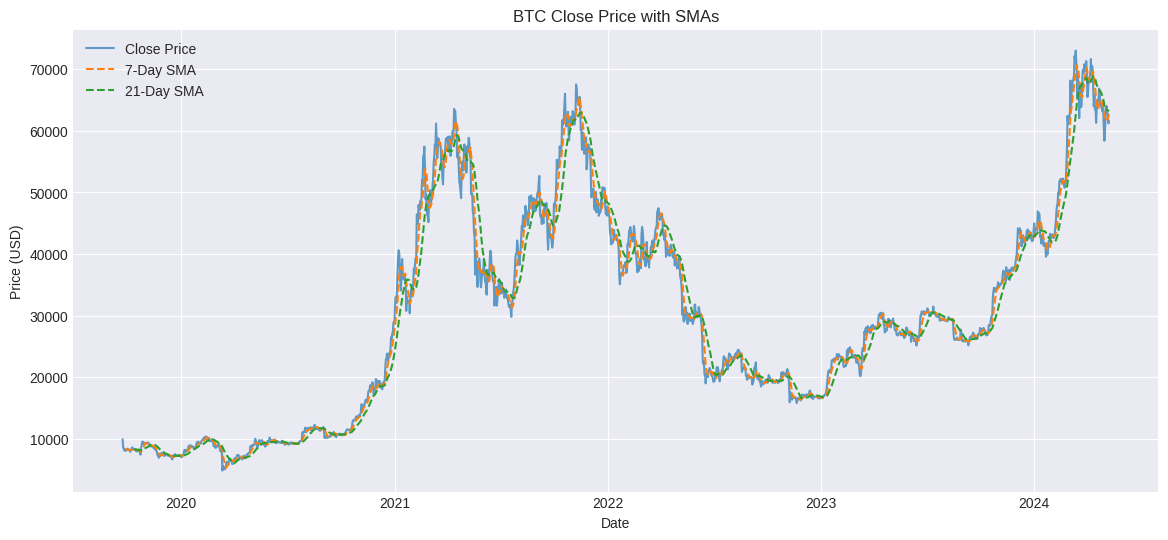

In [100]:
plt.figure(figsize=(14,6))
plt.plot(btc_combined['close'], label='Close Price', alpha=0.7)
plt.plot(btc_combined['sma_7'], label='7-Day SMA', linestyle='--')
plt.plot(btc_combined['sma_21'], label='21-Day SMA', linestyle='--')
plt.title('BTC Close Price with SMAs')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
btc_combined['ema_7'] = btc_combined['close'].ewm(span=7, adjust=False).mean()
btc_combined['ema_21'] = btc_combined['close'].ewm(span=21, adjust=False).mean()

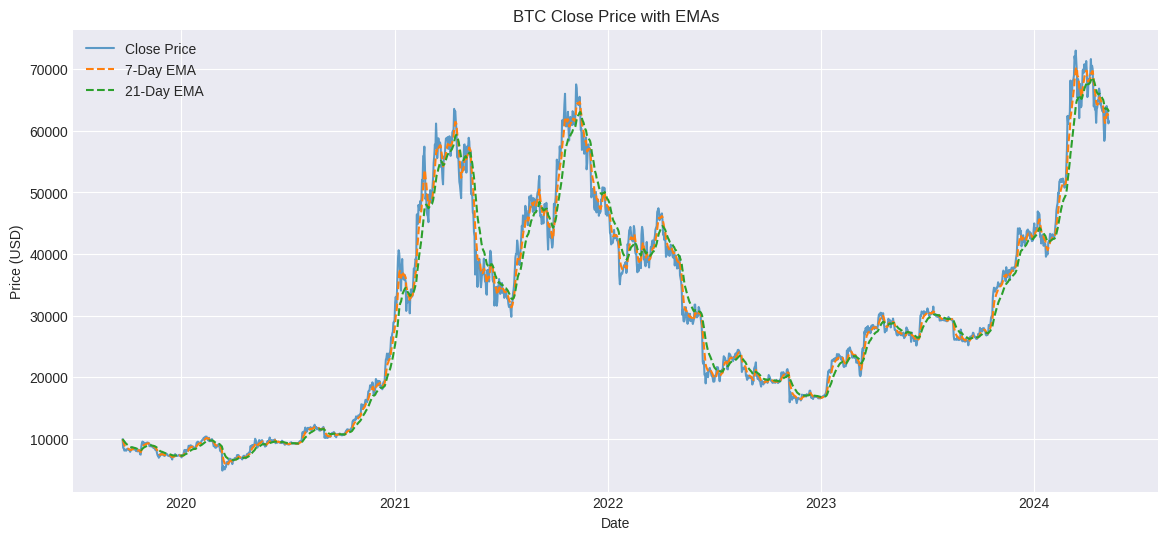

In [102]:
plt.figure(figsize=(14,6))
plt.plot(btc_combined['close'], label='Close Price', alpha=0.7)
plt.plot(btc_combined['ema_7'], label='7-Day EMA', linestyle='--')
plt.plot(btc_combined['ema_21'], label='21-Day EMA', linestyle='--')
plt.title('BTC Close Price with EMAs')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
btc_combined['high_low_spread'] = btc_combined['high'] - btc_combined['low']
btc_combined['close_open_diff'] = btc_combined['close'] - btc_combined['open']
btc_combined['daily_return'] = btc_combined['close'].pct_change()

In [104]:
delta = btc_combined['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
btc_combined['rsi_14'] = 100 - (100 / (1 + rs))


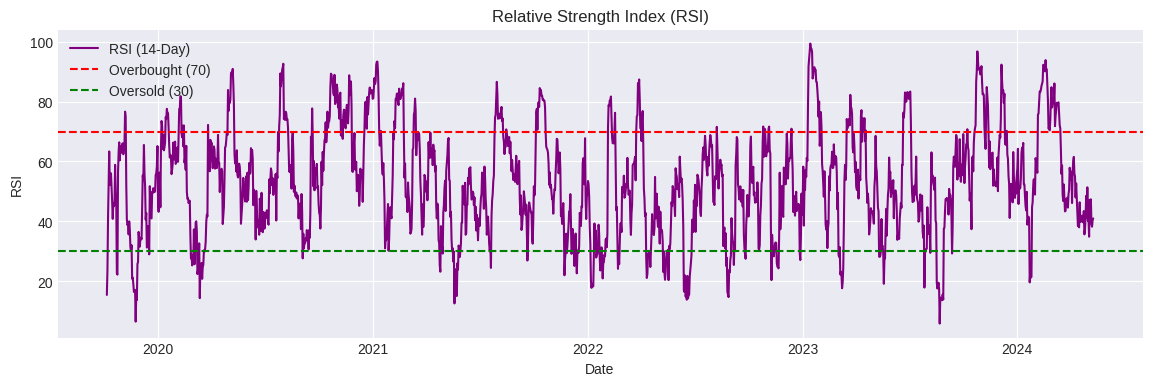

In [105]:
plt.figure(figsize=(14,4))
plt.plot(btc_combined['rsi_14'], label='RSI (14-Day)', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

In [106]:
btc_combined['dayofweek'] = btc_combined.index.dayofweek
btc_combined['month'] = btc_combined.index.month
btc_combined['is_weekend'] = (btc_combined['dayofweek'] >= 5).astype(int)

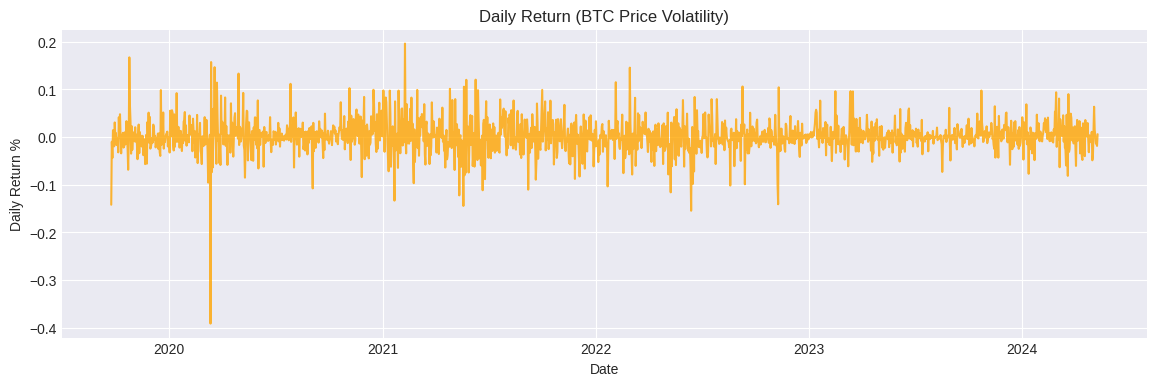

In [107]:
plt.figure(figsize=(14,4))
plt.plot(btc_combined['daily_return'], color='orange', alpha=0.8)
plt.title('Daily Return (BTC Price Volatility)')
plt.xlabel('Date')
plt.ylabel('Daily Return %')
plt.grid(True)
plt.show()

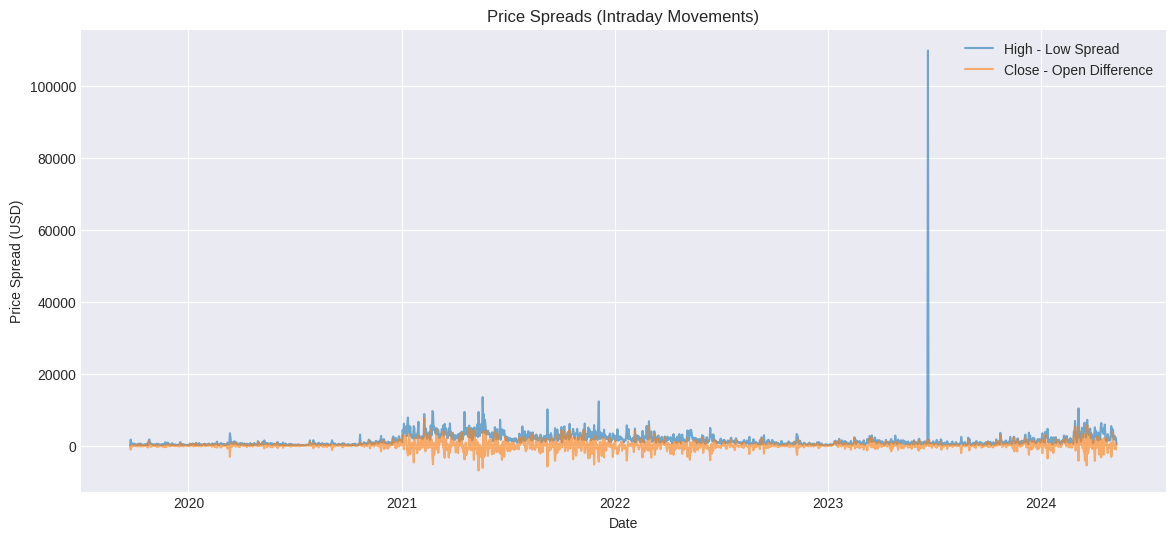

In [108]:
plt.figure(figsize=(14,6))
plt.plot(btc_combined['high_low_spread'], label='High - Low Spread', alpha=0.6)
plt.plot(btc_combined['close_open_diff'], label='Close - Open Difference', alpha=0.6)
plt.title('Price Spreads (Intraday Movements)')
plt.xlabel('Date')
plt.ylabel('Price Spread (USD)')
plt.legend()
plt.grid(True)
plt.show()